In [ ]:
import sys
import os
import pandas as pd
from functions_sgp.data_transformations import build_player_stat_df
from functions_sgp.gambling_odds import cnvt_deci_to_prob

current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(parent_dir)

from functions_nfl.import_nfl_readby_parquet import NFLDataLoader

current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, '..', '..', '..'))
sys.path.append(parent_dir)

from function_library.py_data_visualizations.eda_plots import correlation_heatmap

## Load Data and Perform Merges

In [78]:
seasons = list(range(2014, 2025))

nfl_data_loader = NFLDataLoader()
pbp_import_df = nfl_data_loader.pbp(seasons)
schedule_import_df = nfl_data_loader.schedule(seasons)
player_weekly_import_df = nfl_data_loader.player_weekly(seasons)
team_weekly_import_df = nfl_data_loader.team_weekly(seasons)
depth_df = nfl_data_loader.depth_charts(seasons, schedule_import_df)
player_weekly_df = player_weekly_import_df.merge(depth_df, how='left', on=['season', 'week', 'team', 'player_id'])
player_stat_df = build_player_stat_df(schedule_df=schedule_import_df, player_weekly_df=player_weekly_df)

## Filter player_stat_df to Quarterbacks who attempted at least 5 passes in a given game

In [79]:
qb_df = player_stat_df[(player_stat_df['position']=='QB') & (player_stat_df['attempts']>5)]
qb_df = qb_df[['game_id', 'season', 'week', 'stadium', 'gameday', 'overtime',
 'away_team', 'away_score', 'home_team', 'home_score', 'result', 'total',
 'team_pts', 'opp_pts', 'team_margin', 'away_moneyline', 'home_moneyline',
 'spread_line', 'total_line',
 'away_qb_id', 'home_qb_id', 'away_qb_name', 'home_qb_name', 'away_coach', 'home_coach',
 'player_id', 'player_name',
 'depth_rank', 'depth_position', 'position',
 'team', 'opponent_team',
 'completions', 'attempts', 'passing_yards', 'passing_tds', 'passing_interceptions',
 'sacks_suffered', 'sack_yards_lost', 'sack_fumbles', 'sack_fumbles_lost', 'passing_air_yards', 'passing_yards_after_catch',
 'passing_first_downs', 'passing_epa', 'passing_cpoe', 'passing_2pt_conversions', 'pacr',
 'carries', 'rushing_yards', 'rushing_tds', 'rushing_fumbles', 'rushing_fumbles_lost', 'rushing_first_downs', 'rushing_epa', 'rushing_2pt_conversions']]
qb_df.to_csv("csv_output/qb_df.csv")

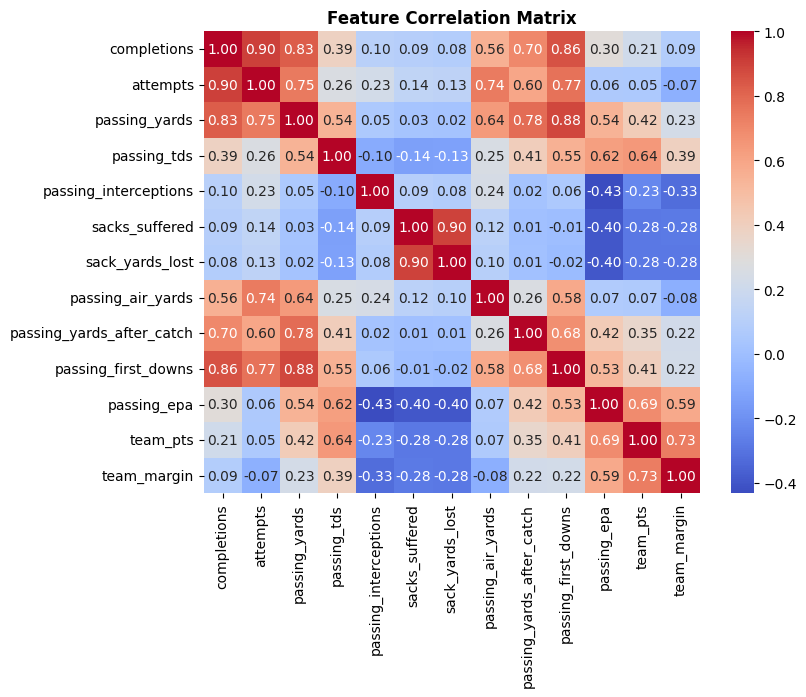

In [ ]:
correlation_heatmap(qb_df, ['completions', 'attempts', 'passing_yards', 'passing_tds', 'passing_interceptions', 'sacks_suffered', 'sack_yards_lost', 
                                      'passing_air_yards', 'passing_yards_after_catch', 'passing_first_downs', 'passing_epa', 'team_pts', 'team_margin'])

## Incorporate Quarterback Statistics Using Conditional Probability Chains

### Conditional Probability Chains (can be adapted to simultaneous events)
    - Even if events are realized at the same time, you can still factor the **joint probability**; this requires that you calculate/estimate the "conditionals" rather than the "full joint"
        - P(A∩B∩C) = P(A) × P(B|A) × P(C|A,B)
    - To start, we will look at: P(A) - spread, P(b) - total, P(c) - passing_td

In [81]:
qb_outcome_conditions = qb_df[(qb_df['team_margin'] > 3.5) & (qb_df['total'] > 49.5)]

In [82]:
print(qb_outcome_conditions['passing_tds'].value_counts(normalize=True))

3.0    0.297461
2.0    0.270859
4.0    0.178960
1.0    0.147521
5.0    0.048368
0.0    0.048368
6.0    0.008464
Name: passing_tds, dtype: float64


### Calculating the P(C) of a QB throwing "n" TD passes based on ALL games where the quarterback's team won by 3.5 points and the total went over 50.5

In [83]:
(qb_outcome_conditions['passing_tds'] > 1.5).mean() * 100

80.41112454655381

## Book Odds on Cowboys -3.5, Over 49.5

In [84]:
print(cnvt_deci_to_prob(3.5))

0.2857142857142857


#### QB with at least 1 Passing TD

In [85]:
print((qb_outcome_conditions['passing_tds'] > 0.5).mean() * cnvt_deci_to_prob(3.5))

0.27189497322508205


In [86]:
print(cnvt_deci_to_prob(3.52)) #odds this happens with Dak 1+ pass td

0.2840909090909091


#### QB with at least 2 Passing TDs

In [87]:
(qb_outcome_conditions['passing_tds'] > 1.5).mean() * cnvt_deci_to_prob(3.5)

0.22974607013301088

In [88]:
print(cnvt_deci_to_prob(3.94)) #odds this happens with Dak 2+ pass td

0.25380710659898476


#### QB with at least 3 Passing TDs

In [89]:
(qb_outcome_conditions['passing_tds'] > 2.5).mean() * cnvt_deci_to_prob(3.5)

0.1523579201934704

In [90]:
print(cnvt_deci_to_prob(5.45)) #odds this happens with Dak 3+ pass td

0.18348623853211007


#### QB with at least 4 Passing TDs

In [91]:
(qb_outcome_conditions['passing_tds'] > 3.5).mean() * cnvt_deci_to_prob(3.5)

0.06736914838486785

In [92]:
print(cnvt_deci_to_prob(10.50)) #odds this happens with Dak 4+ pass td

0.09523809523809523


#### QB with at least 5 Passing TDs

In [93]:
(qb_outcome_conditions['passing_tds'] > 4.5).mean() * cnvt_deci_to_prob(3.5)

0.016237692174814303

In [94]:
print(cnvt_deci_to_prob(29.00)) #odds this happens with Dak 5+ pass tds

0.034482758620689655
